# Fastai 2 medical imaging

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook demonstrates using BentoML to deploy Fastai2 medical image classification model as API server.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=fast-ai&ea=fast-ai2-medical-imaging&dt=fast-ai2-medical-imaging)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
!pip install -U -q fastai>=2.0.13 pydicom>=1.4.0 nbdev>=1.0.0 kornia>=0.4.0 fastcore>=1.0.13

You should consider upgrading via the '/usr/local/anaconda3/envs/dev-py3/bin/python -m pip install --upgrade pip' command.


In [4]:
# from fastai2.data.block import DataBlock, CategoryBlock
# from fastai2.data.external import untar_data, URLs
# from fastai2.data.transforms import RandomSplitter
# from fastai2.metrics import accuracy
# from fastai2.vision.data import ImageBlock
# from fastai2.medical.imaging import get_dicom_files, dcmread, PILDicom
# from fastai2.vision.augment import aug_transforms
# from fastai2.vision.learner import cnn_learner
# from fastai2.vision.models import resnet34
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *


import pydicom

import pandas as pd

import torch
import bentoml.utils.cloudpickle as cloudpickle

In [5]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [6]:
items = get_dicom_files(pneumothorax_source/f"train/")
trn, val = RandomSplitter()(items)

1 frame per file


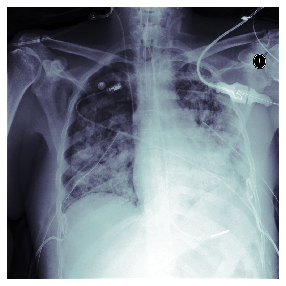

In [7]:
patient = 3
xray_sample = dcmread(items[patient])
xray_sample.show()

In [8]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [9]:
%%writefile datablock_utils.py

from fastai2.data.external import untar_data, URLs

pneumothorax_source = untar_data(URLs.SIIM_SMALL)

def get_x(x):
    return pneumothorax_source/f"{x[0]}"

def get_y(x):
    return x[1]

Overwriting datablock_utils.py


In [10]:
from datablock_utils import get_x, get_y

pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   #get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   #get_y=lambda x:x[1],
                   get_x=get_x,
                   get_y=get_y,
                   batch_tfms=aug_transforms(size=224))

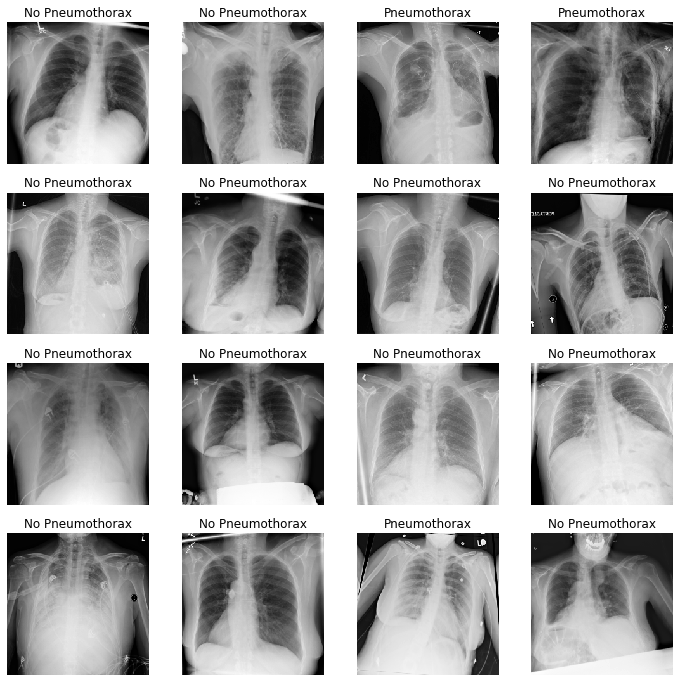

In [11]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

In [12]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.467083,1.219217,0.320000,01:02


In [13]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")


('No Pneumothorax', tensor(0), tensor([0.9334, 0.0666]))

In [20]:
%%writefile medical_image_service.py
from bentoml.frameworks.fastai2 import Fastai2ModelArtifact
from bentoml.adapters import FileInput
from fastcore.utils import tuplify, detuplify

import bentoml
import datablock_utils

@bentoml.artifacts([Fastai2ModelArtifact('learner')])
@bentoml.env(pip_packages=['torch', 'fastai2'])
class FastaiMedicalImagingService(bentoml.BentoService):

    @bentoml.api(input=FileInput(), batch=True)
    def predict(self, files):
        files = [i.read() for i in files]
        dl = self.artifacts.learner.dls.test_dl(files, rm_type_tfms=None, num_workers=0)
        inp, preds, _, dec_preds = self.artifacts.learner.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.artifacts.learner.dls, 'n_inp', -1)
        inp = (inp,)
        dec_list = self.artifacts.learner.dls.decode_batch(inp + tuplify(dec_preds))
        res = []
        for dec in dec_list:
            dec_inp, dec_targ = map(detuplify, [dec[:i], dec[i:]])
            res.append(dec_targ)
        return res

Overwriting medical_image_service.py


In [21]:
import bentoml

from fastcore.utils import remove_patches_path
from medical_image_service import FastaiMedicalImagingService

learn.metrics = []

svc = FastaiMedicalImagingService()
svc.pack('learner', learn)

# Fastcore modify Pathlib module from python, need to remove the patch in order to save
with remove_patches_path():
    saved_path = svc.save()

[2020-09-22 20:59:13,306] WARNING - pip package requirement `fastai2` not found in current python environment
[2020-09-22 20:59:13,308] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
[2020-09-22 20:59:13,321] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-22 20:59:13,323] WARNING - pip package requirement torch already exist
[2020-09-22 20:59:13,918] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/setuptools/dist.py:476: UserWarning: Normalizing '0.9.0.pre+3.gcebf2015.dirty' to '0.9.0rc0+3.gcebf2015.dirty'
  normalized_version,
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.9.0rc0+3.gcebf2015.dirty/bentoml/_version.py
set BentoML-0.9.0rc0+3.gcebf2015.dirty/bentoml/_version.py to '0.9.0.pre+3.gcebf2015.dirty'
[2020-09-22 20:59:17,866] INFO - BentoService bundle 'FastaiMedicalImagingService:20200922205913_3AE93C' saved to: /Users/bozhaoyu/bentoml/repository/FastaiMedicalImagingService/20200922205913_3AE93C


In [16]:
bento_tag = f'{svc.name}:{svc.version}'

## REST API Model Serving

To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [22]:
!bentoml serve FastaiMedicalImagingService:latest

[2020-09-22 20:59:28,325] INFO - Getting latest version FastaiMedicalImagingService:20200922205913_3AE93C
[2020-09-22 20:59:28,326] INFO - Starting BentoML API server in development mode..
[2020-09-22 20:59:28,506] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 20:59:28,520] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015.dirty
[2020-09-22 20:59:30,415] WARNING - pip package requirement `fastai2` not found in current python environment
[2020-09-22 20:59:30,415] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
[2020-09-22 20:59:31,403] W

If you are running this notebook from Google Colab, you can start the dev server with --run-with-ngrok option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com):

In [ ]:
!bentoml serve FastaiMedicalImagingService:atest --run-with-ngrok

### Send prediction request to the REST API server

Go visit http://127.0.0.1:5000/ from your browser, click /predict -> Try it out -> Choose File -> Execute to sumbit an image from your computer

or Using `curl` request:

```
curl -X POST "http://localhost:5000/predict" \
  -F image=@000004.dcm
```

### Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [23]:
!bentoml containerize FastaiMedicalImagingService:latest

[2020-09-22 20:59:55,325] INFO - Getting latest version FastaiMedicalImagingService:20200922205913_3AE93C
Found Bento: /Users/bozhaoyu/bentoml/repository/FastaiMedicalImagingService/20200922205913_3AE93C
[2020-09-22 20:59:55,363] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 20:59:55,380] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015.dirty
Tag not specified, using tag parsed from BentoService: 'fastaimedicalimagingservice:20200922205913_3AE93C'
Building Docker image fastaimedicalimagingservice:20200922205913_3AE93C from FastaiMedicalImagingService:latest 
-we in here
processed docker file
(None, None)
root in create archive /Users/bozhaoyu/bentoml/repository/Fas

/Requirement already satisfied: requests in /opt/conda/lib/python3.7/site-packages (from bentoml==0.9.0.pre->-r ./requirements.txt (line 1)) (2.24.0)
|Requirement already satisfied: protobuf>=3.6.0 in /opt/conda/lib/python3.7/site-packages (from bentoml==0.9.0.pre->-r ./requirements.txt (line 1)) (3.13.0)
-Collecting torchvision>=0.7
/  Downloading torchvision-0.7.0-cp37-cp37m-manylinux1_x86_64.whl (5.9 MB)
/Collecting scikit-learn
\Requirement already satisfied: pip in /opt/conda/lib/python3.7/site-packages (from fastai2->-r ./requirements.txt (line 3)) (20.2.3)
/Collecting spacy
|  Downloading spacy-2.3.2-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
/Collecting pandas
/Collecting fastprogress>=0.2.4
-Collecting matplotlib
/Collecting pyyaml
\Collecting pillow
\Collecting scipy
-  Downloading scipy-1.5.2-cp37-cp37m-manylinux1_x86_64.whl (25.9 MB)
\Requirement already satisfied: yarl<2.0,>=1.0 in /opt/conda/lib/python3.7/site-packages (from aiohttp->bentoml==0.9.0.pre->-r 

|Collecting pytz>=2017.2
\  Downloading pytz-2020.1-py2.py3-none-any.whl (510 kB)
-Collecting kiwisolver>=1.0.1
/  Downloading cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
|Collecting importlib-metadata>=0.20; python_version < "3.8"
\Collecting zipp>=0.5
-Building wheels for collected packages: future, pyyaml
|  Building wheel for future (setup.py): finished with status 'done'
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=dec071dcb8bdef442079d7ff5c364ef85fa9de80326216327406a08c4762eef6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mcjg0e8a/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
-  Building wheel for pyyaml (setup.py): finished with status 'done'
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44619 sha256=90ca2ee45095ac0999e90fe96a3ea9b6136ae85e5b867a13b810d7e120613ed8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mcjg0e8a/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277b

-Requirement already satisfied, skipping upgrade: yarl<2.0,>=1.0 in /opt/conda/lib/python3.7/site-packages (from aiohttp->BentoML==0.9.0rc0+3.gcebf2015.dirty) (1.5.1)
/Requirement already satisfied, skipping upgrade: idna<3,>=2.5 in /opt/conda/lib/python3.7/site-packages (from requests->BentoML==0.9.0rc0+3.gcebf2015.dirty) (2.10)
/  Building wheel for BentoML (PEP 517): finished with status 'done'
|  Created wheel for BentoML: filename=BentoML-0.9.0rc0+3.gcebf2015.dirty-py3-none-any.whl size=3064184 sha256=57f58ae44fcc4beff647947a6578f54e9e06fdff40c74e69e78f9a12a039345b
  Stored in directory: /root/.cache/pip/wheels/09/ed/45/f83b3e5c126046ae57f1c3767cd5bc58206dd4a099a8d9abac
Successfully built BentoML
\Installing collected packages: BentoML
  Attempting uninstall: BentoML
    Found existing installation: BentoML 0.9.0rc0
|    Uninstalling BentoML-0.9.0rc0:
/      Successfully uninstalled BentoML-0.9.0rc0
|Successfully installed BentoML-0.9.0rc0+3.gcebf2015.dirty
\ ---> e988028

In [24]:
!docker run --rm -p 5000:5000 fastaimedicalimagingservice:20200922205913_3AE93C

[2020-09-23 04:04:10,232] INFO - Starting BentoML API server in production mode..
[2020-09-23 04:04:10,654] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-09-23 04:04:10 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-09-23 04:04:10 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-09-23 04:04:10 +0000] [1] [INFO] Using worker: sync
[2020-09-23 04:04:10 +0000] [11] [INFO] Booting worker with pid: 11
[2020-09-23 04:04:10 +0000] [12] [INFO] Booting worker with pid: 12
[2020-09-23 04:04:10 +0000] [13] [INFO] Booting worker with pid: 13
[2020-09-23 04:04:10,875] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 04:04:10,893] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together wit

### Launch inference job from CLI


BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [ ]:
!bentoml run FastaiMedicalImagingService:latest predict \
    --input /Users/bozhaoyu/.fastai/data/siim_small/train/Pneumothorax/000004.dcm

### Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

In [ ]:
from bentoml import load


loaded_svc = load(saved_path)
print(loaded_svc.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm"))

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)